In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import json
from io import StringIO

/tmp/ipykernel_11523/2238799777.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [38]:
from datetime import datetime


# Open VT reports and get SHA256 and first_submission_date values for each json (line).
def extract_first_submission_dates(file_path) -> pd.DataFrame:
    malwares_first_sub_date = []
    with open(file_path, 'r') as reports:
        sha256_key, first_sub_date_key = 'sha256', 'first_submission_date'
        # Iterate through all reports
        for report in reports:
            df_report = pd.read_json(StringIO(report))['data']['attributes']
            sha256, first_sub_date = df_report[sha256_key], df_report[first_sub_date_key]
            malwares_first_sub_date.append((sha256, first_sub_date))

    return pd.DataFrame(malwares_first_sub_date, columns=[sha256_key, first_sub_date_key])


In [39]:
reports_path = './vt/vt_reports67k.jsons'
df_malwares_first_sub_date = extract_first_submission_dates(file_path=reports_path)

df_malwares_first_sub_date.head()

,sha256,first_submission_date
0,98f8e26e12b978102fa39c197f300ebe5fe535617737d5...,1630575593
1,7b2999ffadbc3b5b5c5e94145ca4e2f8de66ac1e3ddd52...,1629375559
2,e7569d494fe00be04ef6c9fcc5e54720c0df623b08e79d...,1362057319
3,1ed60c04f572b6acb9f64c31db55ef5c6b5465bd4da1eb...,1630624233
4,4c4aaff20a57213d9a786e56ad22f1eaa94694a2f1042b...,1592186154


In [40]:
def extract_malware_family(file_path) -> pd.DataFrame:
    df = pd.read_csv(file_path, usecols=['SHA256', 'FAMILY'])
    return df.rename(str.lower, axis='columns')

In [41]:
malware_families_path = "./vt/siggregator_all_samples_no_fuzzy_hash.csv"
df_malware_families = extract_malware_family(file_path=malware_families_path)
df_malware_families.head()

,family,sha256
0,daws,ff4f212ba3b36caa43eacc31a9edf9336e5fb75d7ccaf2...
1,daws,fe4353cc18c5391b2b465fac7b3f2085d420523db2acff...
2,daws,fc168e27287ede856b8e4fbc0673469ec8e62db88e5c18...
3,daws,fb295d4cbf860e1bb12bbb87228fbacb65978f73baacf0...
4,daws,fa2abb1e3133d4e1c873584fd296bbaf7b9d4fc2c49875...


In [52]:
# Join dataframes
df = pd.merge(left=df_malwares_first_sub_date, right=df_malware_families, on='sha256')
df.head()

,sha256,first_submission_date,family
0,98f8e26e12b978102fa39c197f300ebe5fe535617737d5...,1630575593,tnega
1,7b2999ffadbc3b5b5c5e94145ca4e2f8de66ac1e3ddd52...,1629375559,quasar
2,e7569d494fe00be04ef6c9fcc5e54720c0df623b08e79d...,1362057319,pasta
3,1ed60c04f572b6acb9f64c31db55ef5c6b5465bd4da1eb...,1630624233,cjishu
4,4c4aaff20a57213d9a786e56ad22f1eaa94694a2f1042b...,1592186154,kingsoft


array([[<Axes: title={'center': 'first_submission_date'}>]], dtype=object)

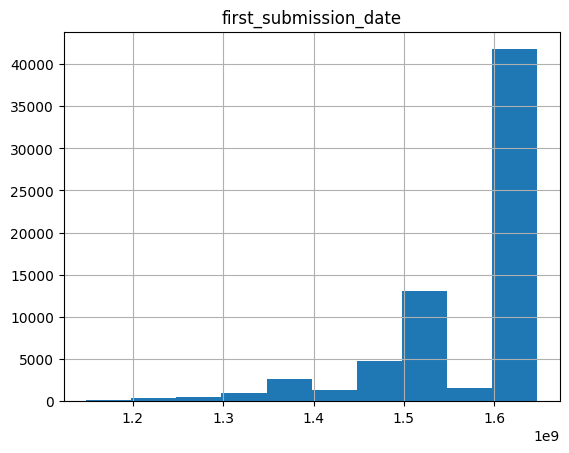

In [43]:
pd.DataFrame.hist(df, )

In [53]:
#distinct_families = df['family'].unique()
#for family in distinct_families:
#    df_family = df[df['family'] == family]
#    #pd.DataFrame.hist(df_family,)
#    sns.displot(df_family, x="first_submission_date", kde=True)
df.head()

,sha256,first_submission_date,family
0,98f8e26e12b978102fa39c197f300ebe5fe535617737d5...,1630575593,tnega
1,7b2999ffadbc3b5b5c5e94145ca4e2f8de66ac1e3ddd52...,1629375559,quasar
2,e7569d494fe00be04ef6c9fcc5e54720c0df623b08e79d...,1362057319,pasta
3,1ed60c04f572b6acb9f64c31db55ef5c6b5465bd4da1eb...,1630624233,cjishu
4,4c4aaff20a57213d9a786e56ad22f1eaa94694a2f1042b...,1592186154,kingsoft


['tnega' 'quasar' 'pasta' 'cjishu' 'kingsoft' 'webcompanion' 'staser'
 'racealer' 'lydra' 'schoolboy']


<Axes: xlabel='first_submission_date', ylabel='family'>

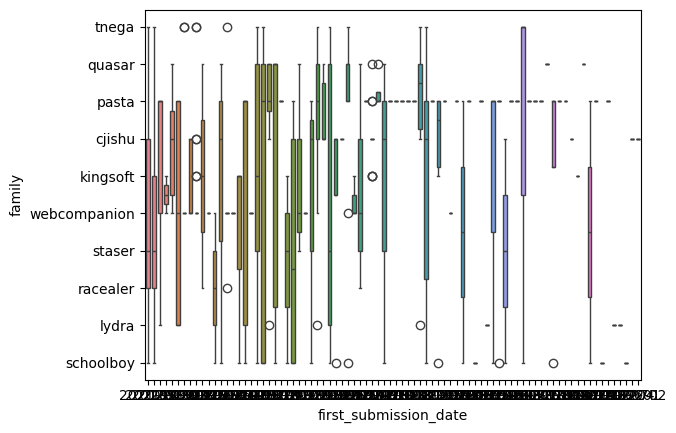

In [72]:
from datetime import timedelta

df1 = df.copy()

families = df1['family'].unique()[:10]
print(families)

df1 = df1[df1['family'].isin(families)]

df1['first_submission_date'] = df1['first_submission_date'].apply(lambda t: pd.to_datetime(t, unit='s'))
df1['first_submission_date'] = df1['first_submission_date'].dt.to_period("6M")

df1['first_submission_date'] = df1['first_submission_date'].apply(lambda t: t.dt.year.astype(str) + 'S' +
                                                                            np.where(t.date.dt.quarter.gt(2), 2, 1).astype(str)
                                                                  )

sns.boxplot(x="first_submission_date", y="family", hue='first_submission_date', data=df1, width=0.6)


In [73]:
df1.head()


,sha256,first_submission_date,family
0,98f8e26e12b978102fa39c197f300ebe5fe535617737d5...,2021-09,tnega
1,7b2999ffadbc3b5b5c5e94145ca4e2f8de66ac1e3ddd52...,2021-08,quasar
2,e7569d494fe00be04ef6c9fcc5e54720c0df623b08e79d...,2013-02,pasta
3,1ed60c04f572b6acb9f64c31db55ef5c6b5465bd4da1eb...,2021-09,cjishu
4,4c4aaff20a57213d9a786e56ad22f1eaa94694a2f1042b...,2020-06,kingsoft
